In [479]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [480]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [481]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [482]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [483]:
# help(PCA)
# help(FastICA)

In [484]:
n_components = 250
whiten='arbitrary-variance'


print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
# pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)


ica  = FastICA(n_components=n_components, algorithm='parallel', whiten=whiten, fun='exp', fun_args=None, 
max_iter=100, tol=0.001, w_init=None, whiten_solver='eigh', random_state=None).fit(X_train)

print("done in %0.3fs" % (time() - t0))

eigenfaces = ica.components_.reshape((n_components, h, w))



# .components_.reshape((n_components, h, w))
t0 = time()

X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 250 eigenfaces from 966 faces


c:\Users\GopalReddyRanjith\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:606: UserWarning: There are some small singular values, using whiten_solver = 'svd' might lead to more accurate results.
  warnings.warn(


done in 1.905s
done in 0.018s


In [485]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_ica, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 5.575s
Best estimator found by grid search:
SVC(C=8177.107110626763, class_weight='balanced', gamma=0.00044574087422112304)


Predicting people's names on the test set
done in 0.137s
                   precision    recall  f1-score   support

     Ariel Sharon       0.55      0.46      0.50        13
     Colin Powell       0.76      0.83      0.79        60
  Donald Rumsfeld       0.62      0.78      0.69        27
    George W Bush       0.95      0.87      0.91       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.77      0.83      0.80        36

         accuracy                           0.81       322
        macro avg       0.72      0.73      0.72       322
     weighted avg       0.82      0.81      0.82       322

Accuracy sore is 0.8136645962732919


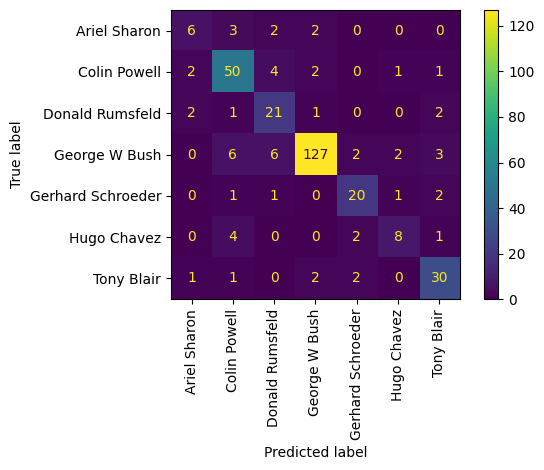

In [486]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_ica)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_ica, y_test, display_labels=target_names, xticks_rotation="vertical"
)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print('Accuracy sore is',score)


plt.tight_layout()
plt.show()

In [487]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [488]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

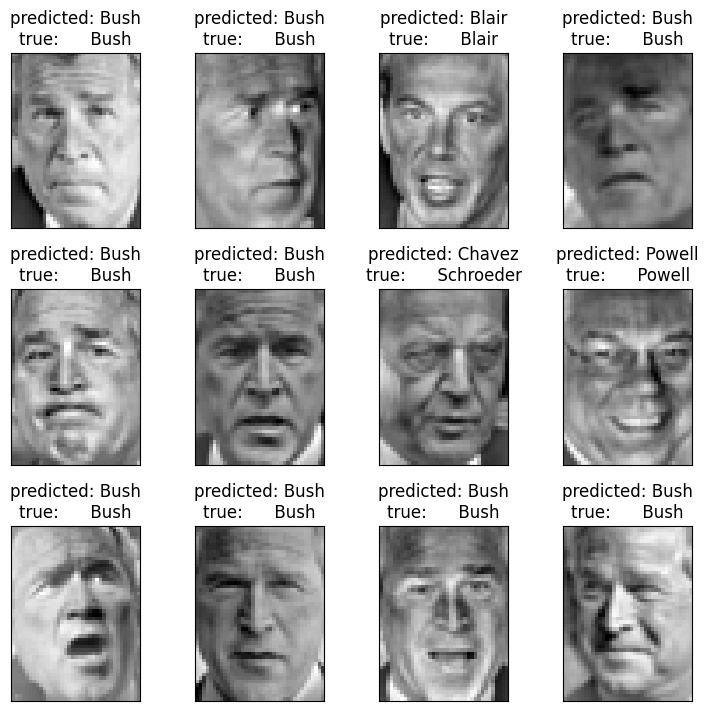

In [489]:
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

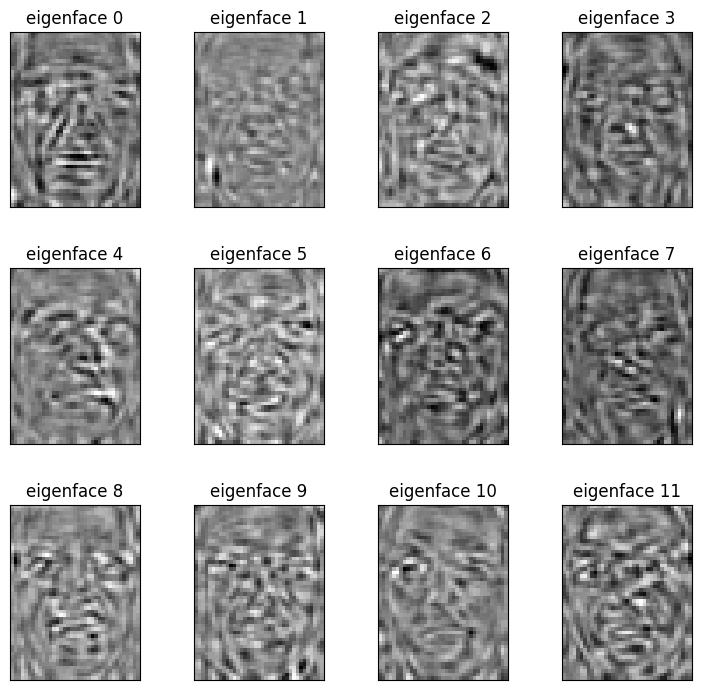

In [490]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()